In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, csv, time
os.chdir('D:/projects/video_regression/code/ml_pl')

import numpy as np
from sklearn.externals import joblib
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import chi2_kernel, rbf_kernel
from multichannel_svr.multichannel_svr import MultiChannelSVR, MultiChannelSVR2

In [36]:
#paths to mappings/features
dataset_root = 'D:/projects/THE_dataset' #directory where features/labels kept
mapping_path = os.path.join(dataset_root, 'ratings_by_filename_it35.csv')
train_path = os.path.join(dataset_root, 'train_set.pkl')
test_path = os.path.join(dataset_root, 'test_set.pkl')
c3d_path = os.path.join(dataset_root, 'C3D_features_wLoad.npz')

In [4]:
#load labels
def load_mapping(mapping_path):
    with open(mapping_path, 'rb') as f:
        import csv
        cr = csv.reader(f)
        mapping_list = []
        for row in cr:
            row[1] = float(row[1])
            mapping_list.append(row)
    return mapping_list            

In [5]:
#function for assigning labels to feature_dict
def assign_label(feature_dict, mapping):
    for ii,name in enumerate(feature_dict['Video_Name']):
        mapping_row = filter(lambda x: x[0] == name[0], mapping)[0]
        label = float(mapping_row[1])
        feature_dict['Label'][ii] = label        
    return feature_dict

In [ ]:
#function - adding in c3d features
def incorporate_c3d(feature_dict, c3d_feats, c3d_names):
    num_instances = len(feature_dict['HOG']) #number of instances
    num_c3d_feats = c3d_feats.shape[1]
    c3d = np.empty((num_instances, num_c3d_feats))
    for ii, video_name in enumerate(feature_dict['Video_Name']):
        ind = np.where(c3d_names == video_name[0])[0][0]
        c3d[ii,:] = c3d_feats[ind,:]
    feature_dict['c3d'] = c3d
    return feature_dict

In [78]:
#function for turning feature_dict into multi-channel tuple
def prep_multichannel_data(feature_dict, return_labels=False, feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy']):
    multichannel_list = []
    for feature in feature_list:
        data = np.array(feature_dict[feature])
        #normalise
        if feature=='c3d':
            data_norm = normalize(data, axis=1, norm='l2')
        else:
            data_norm = normalize(data, axis=1, norm='l1')
        multichannel_list.append(data_norm)    
    if not return_labels:
        return tuple(multichannel_list)
    else:
        labels = feature_dict['Label']
        return tuple(multichannel_list), np.array(labels)

In [67]:
#save the results
def save_results(video_name_list, y_test, y_pred, filename='SVR_final_results.csv'):
    with open(filename, 'wb') as f:
        import csv
        cw = csv.writer(f)
        cw.writerow(['Video_Name', 'y_test', 'y_pred'])
        for ii, name in enumerate(video_name_list):
            row = [name[0], y_test[ii], y_pred[ii]]
            cw.writerow(row) 

In [90]:
#visualise
def plot_regression(y_test, y_pred, title='Regression results'):
    fig, ax = plt.subplots(figsize=(15,12))
    ax.scatter(y_test, y_pred, alpha=.2, s=120)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            linestyle='--', color='k', linewidth=2, label='Perfect prediction')

    ax.set_xlim([10,45])
    ax.set_ylim([10,45])

    ax.set_xlabel(r'Load (observed)', fontsize=16, labelpad=20)
    ax.set_ylabel(r'Load (model)', fontsize=16, labelpad=20)
    ax.set_title(title, fontsize=16)
    ax.legend()
    return fig, ax

In [68]:
#load the datasets
train_set = joblib.load(train_path)
test_set = joblib.load(test_path)
c3d_all = np.load(c3d_path)

In [71]:
mapping = load_mapping(mapping_path)

In [79]:
train_data = assign_label(train_set.feature_dict, mapping)
test_data = assign_label(test_set.feature_dict, mapping)
train_data = incorporate_c3d(train_data, c3d_all['all_fvs'], c3d_all['all_filenames'])
test_data = incorporate_c3d(test_data, c3d_all['all_fvs'], c3d_all['all_filenames'])

In [80]:
feature_list=['Trajectory', 'HOG', 'HOF', 'MBHx', 'MBHy', 'c3d']
X_train, y_train = prep_multichannel_data(train_data, return_labels=True, feature_list=feature_list)
X_test, y_test = prep_multichannel_data(test_data, return_labels=True, feature_list=feature_list)

In [82]:
#define the kernel parameters for each channel
chi2_gammas=(.5,1,1,1,.5)
kernel_param_list = [ {'kernel_func': chi2_kernel, 'param_dict': {'gamma': gamma}} for gamma in chi2_gammas]
kernel_param_list.append( {'kernel_func': rbf_kernel, 'param_dict': {'gamma': 2}} )
kernel_param_tuple = tuple(kernel_param_list)

In [83]:
t0= time.time()
mcsvr = MultiChannelSVR2(num_channels=6, model_param_dict={'C':5}, kernel_param_tuple=kernel_param_tuple)
mcsvr.fit(X_train, y_train)
t1 = time.time()-t0
print 'training time: {0}'.format(t1)

training time: 123.127000093


In [84]:
#predict
y_pred = mcsvr.predict(X_test)
score = r2_score(y_test, y_pred)
print 'R^2 score of {0} \nCorrelation of {1}'.format(score, np.sqrt(score))

R^2 score of 0.641326272675 
Correlation of 0.800828491423


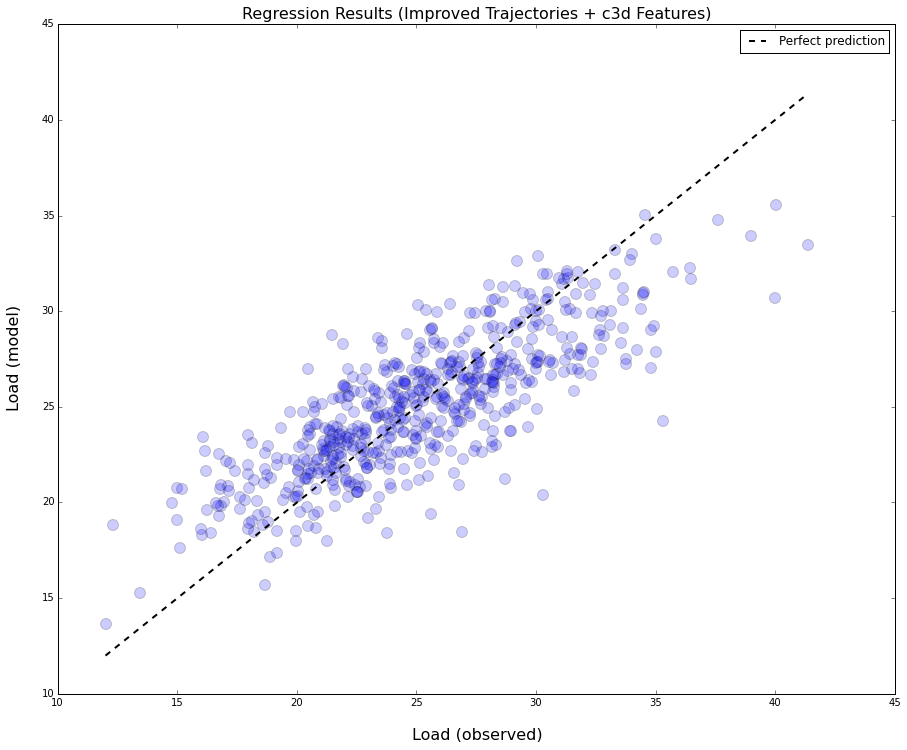

In [91]:
fig, ax = plot_regression(y_test, y_pred, title='Regression Results (Improved Trajectories + c3d Features)')